# OKCupid Clean Data

OKCupid's website returns some partially hidden text when it is too long for their layout.
Lets skip these and just focus on the fully named places.


In [208]:
%matplotlib inline
import time
import pylab
import numpy as np
import pandas as pd
import pycupid.locations

In [5]:
people = pd.read_json('/Users/ajmendez/data/okcupid/random.json')
print('Scraping archive found {:,d} random people'.format(len(people)))

Scraping archive found 337,153 random people


* Locations are generally [city name], [state abbr].
* However there are a number of locations that where too long for the search page and are abbreviated with a unicode u'\u2026'
* Lets ignore these places on our first pass and then return to them later -- ~14% loss of locations

In [271]:
locations = people['location'].astype(unicode)#.replace(r'\s+', np.nan, regex=True)
isgood = (locations.str.extract((u'(\u2026)')).isnull()) & (locations.str.len() > 0)
noriginal = len(locations.unique())
unique_locations = locations[isgood].unique()
nlocations = len(unique_locations)
print('There are a total of {:,d} unique locations and {:,d} good ones'.format(noriginal, nlocations))
print('  > missing locations: {:0.1f}%'.format((noriginal-nlocations)*100.0/noriginal))
print('  > missing people: {:0.1f}%'.format((len(locations)-len(np.where(isgood)[0]))*100.0/len(locations)))

There are a total of 21,689 unique locations and 18,643 good ones
  > missing locations: 14.0%
  > missing people: 5.8%


* Geolocation APIs are have some pretty serious limits, so this was originally run using a cron job nightly to build up a large map of locations to (lat/lon)

In [210]:
# does not seem to pickup the lat/lon notation from the old db
location_map = pd.read_json('/Users/ajmendez/data/okcupid/location_map.json', orient='index')
location_map.columns = ['lat', 'lon']
print('Location cache contains {:,d} locations'.format(len(location_map)))

Location cache contains 16,853 locations


In [ ]:
# load v2:
location_map = pd.read_json('/Users/ajmendez/data/okcupid/locations_v2.json', orient='index')

In [272]:
geonames = pycupid.locations.getGN()
inew = 0
for i, location in enumerate(unique_locations):
    if location in location_map.index:
        continue
    print u'Getting location: {}'.format(location)
    try:
        loc, (lat, lon) = geonames.geocode(location.encode('utf8'))
    except Exception as e:
        print u'  > Failed: {}'.format(location)
#         raise e
    
    # too many loc* names!
    location_map.loc[location] = [lat,lon]
    inew += 1
    
    # give the API a bit of a break
    time.sleep(0.2)
    
    if inew > 1000:
        break
print len(location_map)

20217


In [269]:
location_map.to_json('/Users/ajmendez/data/okcupid/locations_v2.json', orient='index')

# Push data back into dataframe

In [259]:
finished = []
for i, location in enumerate(location_map.index):
    if location in finished:
        continue
    tmp = location_map.loc[location]
    isloc = (locations == location)
    people.loc[isloc, 'lat'] = tmp['lat']
    people.loc[isloc, 'lon'] = tmp['lon']
    people.loc[isloc, 'nloc'] = isloc.sum()
    finished.append(location)
    if (i%1000 == 0):
        print i,
    

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000


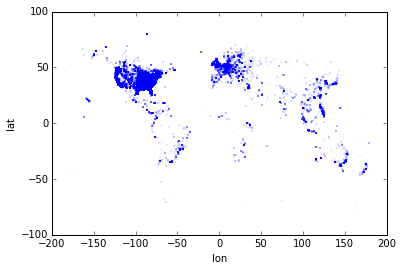

In [279]:
# better plots later, this is just a test
people.plot('lon', 'lat', kind='scatter', s=2, lw=0, alpha=0.1)

In [262]:
people.to_csv('/Users/ajmendez/data/okcupid/random_v2.csv', encoding='utf-8')